# Getting to the Gore of it all...

In this section I will explore various models to predict positive or negative reviews.  Once I find the best model, I will use it to predict other sites as being generally positive to direct my friend Kari to.  

I will be using pipelines to combine Vectorizers with models to test which one is performing the best.  I will be running the models on the premise of:   
1. a complete dataframe consisting of submissions, comments and subset of selftext combined to create a better sample.
2. POSITIVE reviews as 1 and NEGATIVE reviews as 0.


___Table of Contents___

- [Imports](#section1)
- [Testing Environment](#section2)
- [Naive Bayes](#section3)
    - [MB with Count Vectorizer](#section3a)
    - [MB with TfidVectorizer](#section3b)
- [Decision Tree](#section4)

# Imports <a class="anchor" id="section1"></a>

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

#import models
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix, plot_confusion_matrix

# Import vectorizers.
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
from pred_confmatrix import conf_mat

#import ensembles
from sklearn.ensemble import AdaBoostClassifier,VotingClassifier,GradientBoostingClassifier

# Testing Environment  <a class="anchor" id="section2"></a>

In [2]:
df = pd.read_csv('./data/clean_sentiment.csv')
df.dropna(inplace=True)
df

,subreddit,source,body,sentiment,body_len,word_len
0,1.0,sub,slaughter of the vampires 1962 movie trailer p...,0,140,22
1,1.0,sub,dead earth aka two of us 2020 movie trailer pl...,0,178,34
2,1.0,sub,review on ready or not what dose everyone think,1,49,9
3,1.0,sub,new video trailer roh mati paksa indonesia 202...,1,90,13
4,1.0,sub,bloodshot 2020 movie trailer plot ray garrison...,1,113,17
...,...,...,...,...,...,...
4179,0.0,subst,i recently finished american horror story 1984...,1,158,29
4180,0.0,subst,we all know the horror genre has taken a backs...,1,172,34
4181,0.0,subst,i went over 4th of july weekend to see jurassi...,1,445,88
4182,0.0,subst,personally im a huge fan of both ill almost al...,1,1385,257


In [3]:
X = df['body']
y = df['sentiment']

In [4]:
#baseline
y.value_counts(normalize=True)

1    0.735357
0    0.264643
Name: sentiment, dtype: float64

In [5]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,stratify=y,random_state=42)

# Naive Bayes <a class="anchor" id="section3"></a>

## MB with Count Vectorizer <a class="anchor" id="section3a"></a>

In [6]:
mbcvec_pipe = Pipeline([
    ('cvec',CountVectorizer()),
    ('mb',MultinomialNB())
])

params = {'cvec__max_features': [50, 500, 5000], 
                 'cvec__min_df': [2, 3],
                 'cvec__max_df': [.7,.8,.9, .95],
                 'cvec__ngram_range': [(1, 1), (1, 2)],
                 'cvec__stop_words':[None,'english']}

gs = GridSearchCV(mbcvec_pipe,param_grid=params)
gs.fit(X_train,y_train)
print(gs.best_score_)
gs.best_params_

0.8302469714209222


{'cvec__max_df': 0.7,
 'cvec__max_features': 5000,
 'cvec__min_df': 2,
 'cvec__ngram_range': (1, 2),
 'cvec__stop_words': 'english'}

__GridSearchCV Predictions__

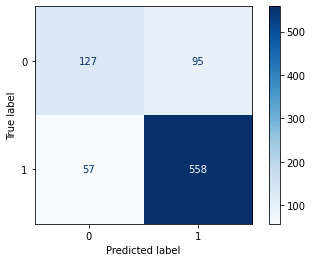

In [7]:
preds_mbcvec = gs.predict(X_test)

tn,fp,fn,tp = confusion_matrix(y_test,preds_mbcvec).ravel()
plot_confusion_matrix (gs,X_test,y_test,cmap='Blues',values_format = 'd');

In [8]:
mbcvec = conf_mat(tn,fp,fn,tp)
mbcvec.all()

Sensitivity is 0.9073170731707317
Specificity is 0.5720720720720721
Precision is 0.8545176110260337
Accuracy is 0.8183990442054958
Misclassification Rate is 0.1816009557945042


## MB with TfidVectorizer <a class="anchor" id="section3b"></a>

In [9]:
mbtvec_pipe = Pipeline([
    ('tvec',TfidfVectorizer()),
    ('mb',MultinomialNB())
])

params = {'tvec__max_features': [50, 500, 5000], 
        'tvec__ngram_range': [(1, 1), (1, 2)],
        'tvec__stop_words':[None,'english'],}

gs = GridSearchCV(mbtvec_pipe,param_grid=params)
gs.fit(X_train,y_train)
print(gs.best_score_)
gs.best_params_

0.8057430337103717


{'tvec__max_features': 5000,
 'tvec__ngram_range': (1, 2),
 'tvec__stop_words': 'english'}

__GridSearchCV Predictions__

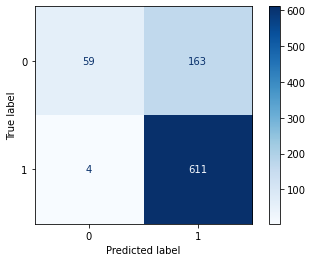

In [10]:
preds_mbtvec = gs.predict(X_test)

tn,fp,fn,tp = confusion_matrix(y_test,preds_mbtvec).ravel()
plot_confusion_matrix (gs,X_test,y_test,cmap='Blues',values_format = 'd');

In [11]:
mbtvec = conf_mat(tn,fp,fn,tp)
mbtvec.all()

Sensitivity is 0.9934959349593496
Specificity is 0.26576576576576577
Precision is 0.789405684754522
Accuracy is 0.8004778972520908
Misclassification Rate is 0.19952210274790916


# Decision Tree <a class="anchor" id="section4"></a>
### Vote ensemble with Boosts, Decision Tree and CountVectorizers
Since the CountVectorizer performed better with this dataset, I will be using that for the Decision Tree

In [12]:
vote = VotingClassifier([
    ('ada',AdaBoostClassifier()),
    ('grad_boost',GradientBoostingClassifier()),
    ('tree',DecisionTreeClassifier())
]) 


pipe = Pipeline([
    ('cvec', CountVectorizer()),
    ('vote', vote)
])

params={'cvec__max_features': [50, 500, 5000], 
        'cvec__min_df': [2, 3],
        'cvec__max_df': [.9, .95],
        'cvec__ngram_range': [(1, 1), (1, 2)],
        'cvec__stop_words':[None,'english'],
        'vote__ada__n_estimators':[50,100,200],
        'vote__grad_boost__n_estimators':[50,100,200]
        }
gs = GridSearchCV(pipe,param_grid=params)
gs.fit(X_train,y_train)
print(gs.best_score_)
gs.best_params_

0.8484800214175758


{'cvec__max_df': 0.9,
 'cvec__max_features': 5000,
 'cvec__min_df': 2,
 'cvec__ngram_range': (1, 2),
 'cvec__stop_words': None,
 'vote__ada__n_estimators': 200,
 'vote__grad_boost__n_estimators': 200}

__GridSearchCV Predictions__

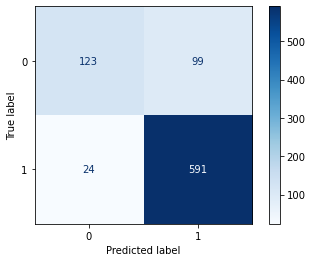

In [13]:
preds_vote = gs.predict(X_test)

tn,fp,fn,tp = confusion_matrix(y_test,preds_vote).ravel()
plot_confusion_matrix (gs,X_test,y_test,cmap='Blues',values_format = 'd');

In [14]:
vote = conf_mat(tn,fp,fn,tp)
vote.all()

Sensitivity is 0.9609756097560975
Specificity is 0.5540540540540541
Precision is 0.8565217391304348
Accuracy is 0.8530465949820788
Misclassification Rate is 0.1469534050179212
